In [1]:
import pandas as pd
import numpy as np

In [2]:
titanic = pd.read_csv("titanic_train.csv")
# titanic.head(30)

数据预处理

In [3]:
#用中间值填充没有Age列没有值的项
#fillna() : 填充NaN值 
#median(): 中间值
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
#titanic.head()
#print titanic.describe()

In [4]:
print titanic["Sex"].unique()
#处理性别，用0表示male 用1表示female
titanic.loc[titanic["Sex"] == "male","Sex"] = 0
titanic.loc[titanic["Sex"] == "female","Sex"] = 1
titanic.head()

['male' 'female']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#处理上船地点 Embarked  
# array(['S', 'C', 'Q', nan]
titanic['Embarked'].unique()

titanic['Embarked']=titanic['Embarked'].fillna('S')
titanic.loc[titanic['Embarked']=='S','Embarked'] = 0
titanic.loc[titanic['Embarked']=='C','Embarked'] = 1
titanic.loc[titanic['Embarked']=='Q','Embarked'] = 2
# 对于缺失值，使用出现比例最高的值  S

# titanic.loc[titanic['Embarked']=='S','Embarked'] = 0
titanic.head(100)

titanic.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

应用机器学习来对样本进行建模

1：线性回归

In [6]:
#线性回归模型
from sklearn.linear_model import LinearRegression
# 交叉验证
from sklearn.model_selection import KFold

In [7]:
# 我们将使用以下列进行学习和预测
predictors = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

# titanic.isnull().sum()

In [8]:
# 初始化模型
lr = LinearRegression()
# 生成交叉验证
kf = KFold(n_splits=3,random_state=1)

#kf = KFold(titanic.shape[0], n_splits=3, random_state=1)

predictions = []
for train,test in kf.split(titanic):
# for train ,test in enumerate(kf,start=1):
    #训练集的输入x
    train_predictors = (titanic[predictors].iloc[train,:])
    #训练集的输出y
    train_target = titanic['Survived'].iloc[train]
    #应用生成的线性回归模型进行学习
    #print train_predictors.shape
    #print train_target.shape
    lr.fit(train_predictors,train_target)
    #然后就行预测 传入验证集
    test_predictions = lr.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)
    #print len(predictions)
    

predictions = np.concatenate(predictions,axis=0)
predictions = pd.Series(predictions)

predictions[predictions > 0.5] =1
predictions[predictions <= 0.5] =0
a= len(predictions[predictions == titanic['Survived']])
b= float(len(predictions))
accuracy = a/b
print  accuracy
 

0.783389450056


随机森林

In [9]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

In [10]:
predictors = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']

#min_samples_split 要分割的最小数据量，大于这个量就不再做分割
#min_samples_leaf 每个叶子的最小数据量 The minimum number of samples required to be at a leaf node. 
rf = RandomForestClassifier(random_state=1,n_estimators=100,min_samples_split=5,min_samples_leaf=2,max_depth=4)

kf = KFold(n_splits=3,random_state=1)
kf = kf.split(titanic)

scores = model_selection.cross_val_score(rf,titanic[predictors],titanic['Survived'],cv=kf)

print float(scores.mean())

0.820426487093


加入新的特征

In [11]:

titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']

titanic['NameLength'] = titanic['Name'].apply(lambda x:len(x))

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,NameLength
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,51
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,44
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,24


获取人物头衔 title

In [14]:
#正则模块
import re

In [15]:
# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [19]:
titles = titanic['Name'].apply(get_title)
#print (pd.value_counts(titles))

title_mapping =  {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] =v
#把头衔转换为数字
# print(pd.value_counts(titles))

titanic['Title'] = titles

In [20]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,NameLength,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,23,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,1,51,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,22,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,44,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,24,1


查看每个特征的重要程度，看去除一个特征后对整体的影响

In [21]:
from sklearn.feature_selection import SelectKBest,f_classif
import matplotlib.pyplot as plt

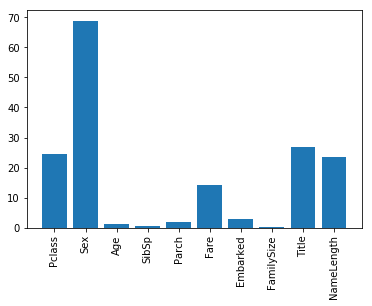

In [35]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "NameLength"]

#创建特征选择器
#k:Number of top features to select. 
#f_classif(X, y)[source] :Compute the ANOVA方差分析 F-value for the provided sample.
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors],titanic['Survived'])

#获取 raw p-values for each feature, then transform from p-values into scores
scores = -np.log10(selector.pvalues_)
# print scores

#draw the picture: plot the scores, See how 'Pclass' , 'Sex', ...  perform?
plt.bar(range(len(predictors)),scores)

#坐标标注
plt.xticks(range(len(predictors)),predictors,rotation='vertical')
plt.show()

#选取4个最好的特征
predictors = ['Pclass','Sex','Fare','Title']

In [37]:
#创建随机森林模型
rf = RandomForestClassifier(random_state=1, n_estimators=100,min_samples_leaf=4,min_samples_split=8)

kf = KFold(n_splits=3,random_state=1)
kf = kf.split(titanic)
scores = model_selection.cross_val_score(rf,titanic[predictors],titanic['Survived'],cv=kf)

# print float(scores.mean())

0.818181818182


boosting 提升学习  梯度提升决策树

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


In [72]:
# 算法集合
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25,max_depth=3),["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title",]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(n_splits=3,random_state=1)
kf = kf.split(titanic)

predictions = []
for train ,test in kf:
    train_target = titanic['Survived'].iloc[train]
    full_test_predictions = []
    
    #make predictions for each algorithm on each fold 
    for alg,predictors in algorithms:
        #fit the algorithms
        alg.fit(titanic[predictors].iloc[train,:],train_target)
        #select and predict on test fold
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    #use sample ensembling schema: average the predictions to the the final classification
    test_predictions = (full_test_predictions[0] + full_test_predictions[1])/2
    test_predictions[test_predictions<= 0.5]  = 0
    test_predictions[test_predictions> 0.5]  = 1
    predictions.append(test_predictions)
    

predictions=np.concatenate(predictions,axis=0)
a= len(predictions[predictions == titanic['Survived']])
b= float(len(predictions))
accuracy = a/b
print  accuracy

0.821548821549


尝试获取其他 特征

In [96]:
titanic_test = pd.read_csv('test.csv')
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test.head()

titanic_test.loc[titanic_test["Sex"] == "male","Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female","Sex"] = 1
titanic_test.head()


titanic_test['Embarked'].unique()

titanic_test['Embarked']=titanic_test['Embarked'].fillna('S')
titanic_test.loc[titanic_test['Embarked']=='S','Embarked'] = 0
titanic_test.loc[titanic_test['Embarked']=='C','Embarked'] = 1
titanic_test.loc[titanic_test['Embarked']=='Q','Embarked'] = 2
# 对于缺失值，使用出现比例最高的值  S

# titanic.loc[titanic['Embarked']=='S','Embarked'] = 0

titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test['Age'].median())
titanic_test['Fare'] = titanic_test['Fare'].fillna(1)

# titanic_test.isnull().sum()

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


In [135]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=100, max_depth=8), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 8 + full_predictions[1]) / 9

# titanic_test['Survived']

predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
 
# predictions=np.concatenate(predictions,axis=0)
a= len(predictions[predictions == titanic['Survived']])
b= float(len(predictions))
accuracy = a/b
print  accuracy



0.982042648709
